# This trains the model according to a set of dates and saves them down

In [1]:
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
###################################################
import torch
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.model_selection import train_test_split
###################################################
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
###################################################
from livelossplot import PlotLosses
import hiddenlayer as hl
###################################################
import pickle
import os
###################################################
import scipy as sp
import scipy.fftpack

In [2]:
temp_nc = netCDF4.Dataset('../eniko/data/tas/tas_day_MPI-ESM-MR_rcp85_r1i1p1_g025.nc')
temp_ncdata_3D = np.array(temp_nc.variables['tas'])
temp_ncdata_2D = temp_ncdata_3D.reshape(temp_ncdata_3D.shape[0], temp_ncdata_3D.shape[1]*temp_ncdata_3D.shape[2])        

dates = pd.to_datetime(netCDF4.num2date(temp_nc.variables['time'][:], temp_nc.variables['time'].units)).year
temp_ncdata_df = pd.DataFrame(temp_ncdata_2D, index = dates)

In [38]:
train_start = 2025
train_end = 2100

test_start = 1975
test_end = 2000

max_fts = 10
batch_size = 1206

In [39]:
# PCA type
train_idx = temp_ncdata_df.index.isin(range(train_start,train_end+1))
train_samples = temp_ncdata_df.iloc[train_idx]
train_years = temp_ncdata_df.index[temp_ncdata_df.index.isin(range(train_start,train_end+1))]

test_idx = temp_ncdata_df.index.isin(range(test_start,test_end+1))
test_samples = temp_ncdata_df.iloc[test_idx]
test_years = temp_ncdata_df.index[temp_ncdata_df.index.isin(range(test_start,test_end+1))]

# Standardise the training samples
train_samples = torch.tensor(train_samples.values)#.double()
test_samples = torch.tensor(test_samples.values)#.double()

mu, sig = train_samples.mean(), train_samples.std()

# train_samples = train_samples.sub(mu).div(sig)
# test_samples = test_samples.sub(mu).div(sig)

mmin = min(train_samples.min(),test_samples.min())
mmax = max(train_samples.max(),test_samples.max())

# # Normalise instead
train_samples = (train_samples - mmin) / (mmax - mmin)
test_samples = (test_samples - mmin) / (mmax - mmin)


train_data = DataLoader(train_samples, batch_size=batch_size)
test_data = DataLoader(test_samples, batch_size=batch_size)

In [5]:
# AE type (reshaped)
train_data_ae = DataLoader(train_samples.reshape(-1, 72, 144), batch_size=batch_size)
test_data_ae = DataLoader(test_samples.reshape(-1, 72, 144), batch_size=batch_size)

In [6]:
dataloaders = {
    "train": train_data_ae,
    "validation": test_data_ae
}

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Train PCA

In [41]:
pcs = np.linspace(19, 20, 2)

In [42]:
pcs

array([19., 20.])

In [43]:
train_data.dataset.shape

torch.Size([27758, 10368])

In [45]:
# Train the PCA and save it
# max_fts = 512
# i=max_fts
for i in tqdm(pcs):
    # Intialise IncrementalPCA
    iPCA = IncrementalPCA(n_components=int(i))

    # Loop over the training batch
    for train_dat in tqdm(train_data):
        iPCA.partial_fit(train_dat)

    model_name = 'data/models/pca/pca_{}_{}_to_{}.pickle'.format(int(i), train_start, train_end)
    os.makedirs(os.path.dirname(model_name), exist_ok=True)

    with open(model_name, 'wb') as f:
        pickle.dump(iPCA, f)









  0%|          | 0/2 [00:00<?, ?it/s]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:01<00:45,  1.96s/it]








  8%|▊         | 2/24 [00:03<00:41,  1.88s/it]








 12%|█▎        | 3/24 [00:05<00:37,  1.80s/it]








 17%|█▋        | 4/24 [00:06<00:34,  1.74s/it]








 21%|██        | 5/24 [00:08<00:32,  1.69s/it]








 25%|██▌       | 6/24 [00:10<00:31,  1.73s/it]








 29%|██▉       | 7/24 [00:11<00:29,  1.72s/it]








 33%|███▎      | 8/24 [00:13<00:27,  1.73s/it]








 38%|███▊      | 9/24 [00:15<00:25,  1.70s/it]








 42%|████▏     | 10/24 [00:17<00:24,  1.76s/it]








 46%|████▌     | 11/24 [00:18<00:22,  1.73s/it]








 50%|█████     | 12/24 [00:20<00:20,  1.72s/it]








 54%|█████▍    | 13/24 [00:22<00:18,  1.71s/it]








 58%|█████▊    | 14/24 [00:24<00:17,  1.74s/it]








 62%|██████▎   | 15/24 [00:25<00:15,  1.70s/it]








 67%|██████▋   | 16/24 [00:27<00:13,  1.70s/it]








 71%|███████

In [8]:
with open('data/models/pca/pca_5_2025_to_2100.pickle', 'rb') as file:
    pca_model = pickle.load(file)

In [9]:
pca_model

IncrementalPCA(batch_size=None, copy=True, n_components=5, whiten=False)

In [57]:
recon_img = np.empty(shape=(0,72*144))

In [58]:
for test_dat in test_data:
    transformed_img = pca_model.transform(test_dat)
    inv = pca_model.inverse_transform(transformed_img)
    recon_img = np.append(recon_img, inv, axis=0)

# Train autoencoder

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, layers):
        super(AutoEncoder,self).__init__()
        assert len(layers) == 5, 'Not the right number of layer numbers'
        self.encoder = nn.Sequential(
            nn.Conv2d(1, layers[0], kernel_size=(3,5))
            ,nn.MaxPool2d(2)
            ,nn.ReLU()
            
            ,nn.Conv2d(layers[0], layers[1], kernel_size=(2,5))
            ,nn.MaxPool2d((2,3))
            ,nn.ReLU()
            
            ,nn.Conv2d(layers[1], layers[2], kernel_size=(2,3))
            ,nn.MaxPool2d(2)
            ,nn.ReLU()
            
            ,nn.Conv2d(layers[2], layers[3], kernel_size=(3,3))
            ,nn.MaxPool2d(2)
            ,nn.ReLU()
            
            ,nn.Conv2d(layers[3], layers[4], kernel_size=(2,3))
            ,nn.MaxPool2d(2)
        )
        
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(layers[4], layers[3], kernel_size=(3,4), stride=(3,4))
            ,nn.ReLU()
                    
            ,nn.ConvTranspose2d(layers[3], layers[2], kernel_size=(3,3), stride=(3,3))
            ,nn.ReLU()
            
            ,nn.ConvTranspose2d(layers[2], layers[1], kernel_size=(2,3), stride=(2,3))
            ,nn.ReLU()
            
#             ,nn.PixelShuffle(2)
            
            ,nn.ConvTranspose2d(layers[1], layers[0], kernel_size=2, stride=2)
            ,nn.ReLU()
                       
            ,nn.ConvTranspose2d(layers[0], 1, kernel_size=(2,2), stride=(2,2))
            ,nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder part
        y = self.encoder(x)
        # Decoder part
        x = self.decoder(y)
        return y, x # x is the output of the autoencoder, y is the output of the encoder

In [24]:
x = torch.tensor(np.random.random((1, 1, 72, 144))).float()

In [4]:
model = AutoEncoder(layers=[4,8,16,32,64])
summary(model, (1, 72, 144))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 70, 140]              64
         MaxPool2d-2            [-1, 4, 35, 70]               0
              ReLU-3            [-1, 4, 35, 70]               0
            Conv2d-4            [-1, 8, 34, 66]             328
         MaxPool2d-5            [-1, 8, 17, 22]               0
              ReLU-6            [-1, 8, 17, 22]               0
            Conv2d-7           [-1, 16, 16, 20]             784
         MaxPool2d-8            [-1, 16, 8, 10]               0
              ReLU-9            [-1, 16, 8, 10]               0
           Conv2d-10             [-1, 32, 6, 8]           4,640
        MaxPool2d-11             [-1, 32, 3, 4]               0
             ReLU-12             [-1, 32, 3, 4]               0
           Conv2d-13             [-1, 64, 2, 2]          12,352
        MaxPool2d-14             [-1, 6

In [36]:
def train_model(model, criterion, optimizer, bottleneck, num_epochs=20):
    liveloss = PlotLosses(skip_first=2
                          ,max_cols=1
                          ,fig_path='data/images/autoencoder/train_test_loss_{}_over_{}_epochs.pdf'.format(bottleneck, num_epochs))
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs in dataloaders[phase]:
                
                inputs = inputs.to(device).unsqueeze(1)
                _, outputs = model(inputs)
                
                loss = criterion(inputs, outputs)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.detach() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'MSE loss'] = epoch_loss.item()
        
        liveloss.update(logs)
        liveloss.draw()
    
    return model

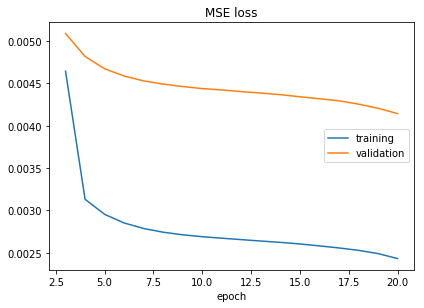

MSE loss:
training   (min:    0.002, max:    0.041, cur:    0.002)
validation (min:    0.004, max:    0.013, cur:    0.004)


In [13]:
# This will train the model
num_epochs = 20
bottleneck= 64

# Initialise AE
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.MSELoss()

# Start training
trained_model = train_model(model, criterion, optimizer, bottleneck, num_epochs)

In [14]:
model_name = 'data/models/autoencoder/ae_{}_{}_to_{}_{}_epochs.pickle'.format(bottleneck, train_start, train_end, num_epochs)
os.makedirs(os.path.dirname(model_name), exist_ok=True)

torch.save(trained_model.state_dict(), model_name)

# Run PCA on autoencoder

In [10]:
bottleneck=64

In [11]:
ae_model = 'data/models/autoencoder/ae_reg_{}_2025_to_2100_20_epochs.pickle'.format(bottleneck)

In [12]:
model = AutoEncoder(layers=[4,8,16,32,64])

model.load_state_dict(torch.load(ae_model))
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(4, 8, kernel_size=(2, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(2, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(32, 64, kernel_size=(2, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 4), stride=(3, 4))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(

In [13]:
test_data_ae.dataset.shape

torch.Size([9497, 72, 144])

In [14]:
max_pcs = 64
iPCA = IncrementalPCA(n_components=max_pcs)

# Recompute the batch size to make it easier for the IPCA
test_data_ae = DataLoader(test_samples.reshape(-1, 72, 144), batch_size=100)

ae_ts = np.empty(shape=(0,bottleneck))
pca_from_ae_ts = np.empty(shape=(0,max_pcs))

for test_dat in tqdm(test_data_ae):      
    encoded, _ = model(test_dat.unsqueeze(1))
    iPCA.partial_fit(encoded.detach().numpy().reshape(-1,bottleneck))
    
#     transformed_img = iPCA.transform(encoded.detach().numpy().reshape(-1,bottleneck))

#     ae_ts = np.append(ae_ts, encoded.detach().numpy().reshape(-1,bottleneck), axis=0)
#     pca_from_ae_ts = np.append(pca_from_ae_ts, transformed_img, axis=0)
    

100%|██████████| 95/95 [00:04<00:00, 20.73it/s]


In [15]:
model_name = 'data/models/autoencoder/pca_on_ae_reg_{}_{}_to_{}.pickle'.format(bottleneck, train_start, train_end)
os.makedirs(os.path.dirname(model_name), exist_ok=True)

with open(model_name, 'wb') as f:
    pickle.dump(iPCA, f)

# Annual data models

In [4]:
temp_nc = netCDF4.Dataset('../eniko/data/tas/tas_ann_MPI-ESM-MR_rcp85_r1i1p1_g025.nc')
temp_ncdata_3D = np.array(temp_nc.variables['tas'])
temp_ncdata_2D = temp_ncdata_3D.reshape(temp_ncdata_3D.shape[0], temp_ncdata_3D.shape[1]*temp_ncdata_3D.shape[2])        

# dates = pd.to_datetime(netCDF4.num2date(temp_nc.variables['time'][:], temp_nc.variables['time'].units)).year
# temp_ncdata_df = pd.DataFrame(temp_ncdata_2D, index = dates)

In [ ]:
# 231 years from 1870 to 2100

In [12]:
40/(160)

0.25

In [112]:
train_start = 1870
train_end = 1989

test_start = 2081
test_end = 2100

max_fts = 10
batch_size = 32

In [113]:
# PCA type
train_samples = temp_ncdata_2D[0:120]

test_samples = temp_ncdata_2D[-20-1:-1]

# Standardise the training samples
train_samples = torch.tensor(train_samples)#.double()
test_samples = torch.tensor(test_samples)#.double()

mu, sig = train_samples.mean(), train_samples.std()

# train_samples = train_samples.sub(mu).div(sig)
# test_samples = test_samples.sub(mu).div(sig)

mmin = min(train_samples.min(),test_samples.min())
mmax = max(train_samples.max(),test_samples.max())

# # Normalise instead
train_samples = (train_samples - mmin) / (mmax - mmin)
test_samples = (test_samples - mmin) / (mmax - mmin)


train_data = DataLoader(train_samples, batch_size=batch_size)
test_data = DataLoader(test_samples, batch_size=batch_size)

In [114]:
train_samples.shape, test_samples.shape

(torch.Size([120, 10368]), torch.Size([20, 10368]))

In [115]:
# Train the PCA and save it
max_fts = 120
i=max_fts
# for i in tqdm(range(1,max_fts+1)):
    # Intialise IncrementalPCA
_PCA = PCA(n_components=i)

_PCA.fit(train_samples)

# model_name = 'data/models/pca/pca_annual_{}_{}_to_{}.pickle'.format(i, train_start, train_end)
# os.makedirs(os.path.dirname(model_name), exist_ok=True)

# with open(model_name, 'wb') as f:
#     pickle.dump(_PCA, f)

PCA(copy=True, iterated_power='auto', n_components=120, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [116]:
model_name = 'data/models/pca/pca_annual_{}_{}_to_{}.pickle'.format(i, train_start, train_end)
os.makedirs(os.path.dirname(model_name), exist_ok=True)

with open(model_name, 'wb') as f:
    pickle.dump(_PCA, f)

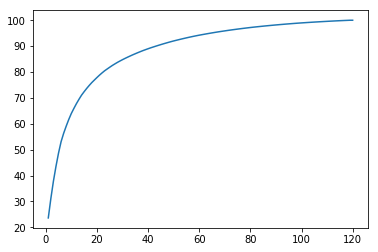

In [117]:
plt.plot(range(1,120+1),np.cumsum(_PCA.explained_variance_ratio_)*100)

In [118]:
def train_model(model, criterion, optimizer, bottleneck, num_epochs=20, data_type='annual'):
    liveloss = PlotLosses(skip_first=2
                          ,max_cols=1
                          ,fig_path='data/images/autoencoder/train_test_loss_{}_{}_over_{}_epochs.pdf'.format(data_type, bottleneck, num_epochs))
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs in dataloaders[phase]:
                
                inputs = inputs.to(device).unsqueeze(1)
                _, outputs = model(inputs)
                
                loss = criterion(inputs, outputs)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.detach() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'MSE loss'] = epoch_loss.item()
        
        liveloss.update(logs)
        liveloss.draw()
    
    return model

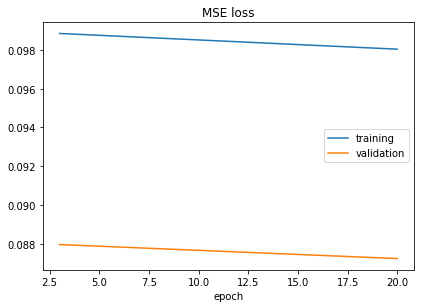

MSE loss:
training   (min:    0.098, max:    0.099, cur:    0.098)
validation (min:    0.087, max:    0.088, cur:    0.087)


In [120]:
# This will train the model
num_epochs = 20
bottleneck= 64

# Initialise AE
model = AutoEncoder(layers=[4,8,16,32,64])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.MSELoss()

# Start training
trained_model = train_model(model, criterion, optimizer, bottleneck, num_epochs)

In [121]:
model_name = 'data/models/autoencoder/ae_annual_{}_{}_to_{}_{}_epochs.pickle'.format(bottleneck, train_start, train_end, num_epochs)
os.makedirs(os.path.dirname(model_name), exist_ok=True)

torch.save(trained_model.state_dict(), model_name)

# Visualise the annual models

In [122]:
def time_freq_pair(datelist, series, series_type, components, test_start, test_end, bottleneck):
    fig, ax = plt.subplots(16,4, figsize=(20,30))
    
    for i in range(16):
    
        ax[i, 0].plot(datelist, series[:,i], color="black")
        if i == 15:
            ax[i, 0].tick_params(axis="x", labelsize=10, rotation=45)    
        if i != 15:    
            ax[i, 0].set_xticks([])
#         ax[i, 0].set_yticks([])
        ax[i, 0].yaxis.tick_left()
        ax[i, 0].grid('off')
        ax[i, 0].set_ylabel('c {}'.format(components[i], fontsize=16, color='r'))

        signal_fft = sp.fftpack.fft(series[:,i])
        power_spectrum = np.abs(signal_fft) ** 2
        fftfreq = sp.fftpack.fftfreq(len(power_spectrum), 1. / 1.)# 365) # The frequencies will come out as YEARLY if we do this
        j = fftfreq > 0 # Only get the real ones
        ax[i, 1].loglog(fftfreq[j], power_spectrum[j], color="black")
        ax[i, 1].set_xlim(0.1, 370)
        if i == 15:
            ax[i, 1].set_xlabel('Frequency (1 / year)', fontsize=10)
            ax[i, 1].tick_params(axis="x", labelsize=10, rotation=0) 
        if i != 15:
            ax[i, 1].set_xticks([])
        ax[i, 1].yaxis.tick_right()
        ax[i, 1].set_ylim(0.01, 1e9)
        ax[i, 1].axvline(x=1, linewidth=1, color='green')
        ax[i, 1].axvline(x=2, linewidth=1, color='green')
        ax[i, 1].axvline(x=3, linewidth=1, color='green')
        ax[i, 1].axvline(x=4, linewidth=1, color='red')
        ax[i, 1].axvline(x=12, linewidth=1, color='red')
                            
        ax[i, 2].plot(datelist, series[:,i+16], color="black")
        if i == 15:
            ax[i, 2].tick_params(axis="x", labelsize=10, rotation=45)    
        if i != 15:    
            ax[i, 2].set_xticks([])
#         ax[i, 2].set_yticks([])
        ax[i, 2].yaxis.tick_left()
        ax[i, 2].grid('off')
        ax[i, 2].set_ylabel('c {}'.format(components[i+16], fontsize=16, color='r'))

        signal_fft = sp.fftpack.fft(series[:,i+16])
        power_spectrum = np.abs(signal_fft) ** 2
        fftfreq = sp.fftpack.fftfreq(len(power_spectrum), 1. / 1.)#365) # The frequencies will come out as YEARLY if we do this
        j = fftfreq > 0 # Only get the real ones
        ax[i, 3].loglog(fftfreq[j], power_spectrum[j], color="black")
        ax[i, 3].set_xlim(0.1, 370)
        if i == 15:
            ax[i, 3].set_xlabel('Frequency (1 / year)', fontsize=10)
            ax[i, 3].tick_params(axis="x", labelsize=10, rotation=0) 
        if i != 15:
            ax[i, 3].set_xticks([])
        ax[i, 3].yaxis.tick_right()
        ax[i, 3].set_ylim(0.01, 1e9)
        ax[i, 3].axvline(x=1, linewidth=1, color='green')
        ax[i, 3].axvline(x=2, linewidth=1, color='green')
        ax[i, 3].axvline(x=3, linewidth=1, color='green')
        ax[i, 3].axvline(x=4, linewidth=1, color='red')
        ax[i, 3].axvline(x=12, linewidth=1, color='red')
    
    fig.tight_layout()
    
    if series_type == 'pca_on_ae':
        fig.savefig('data/images/{}/annual_series_components_pc_on_ae_bottleneck_{}_{}_to_{}_for_{}_{}.pdf'.format('autoencoder',bottleneck,components[0],components[-1],test_start,test_end))
    else:    
        fig.savefig('data/images/{}/annual_series_components_autoencoder_bottleneck_{}_{}_to_{}_for_{}_{}.pdf'.format(series_type,bottleneck,components[0],components[-1],test_start,test_end))
                            


In [123]:
bottleneck=64

model=AutoEncoder(layers=[4,8,16,32,64])

pca_ts = np.empty(shape=(0,120))
ae_ts = np.empty(shape=(0,bottleneck))
# pca_on_ae_ts = np.empty(shape=(0,64)) 

In [124]:
pca_model = _PCA

In [145]:
ae_on_pca = PCA(n_components=20)

In [125]:
for test_dat in tqdm(test_data):      
    # Plain PCA
    transformed_img = pca_model.transform(test_dat)
    pca_ts = np.append(pca_ts, transformed_img, axis=0)
    
    # Autoencoder
    encoded, _ = model(test_dat.reshape(-1, 72, 144).unsqueeze(1))
    ae_ts = np.append(ae_ts, encoded.detach().numpy().reshape(-1,bottleneck), axis=0)
    
    # PCA on autoencoder
#     transformed_img_bottleneck = pca_on_ae_model.transform(encoded.detach().numpy().reshape(-1,bottleneck))
#     pca_on_ae_ts = np.append(pca_on_ae_ts, transformed_img_bottleneck, axis=0)

100%|██████████| 1/1 [00:00<00:00, 29.60it/s]


In [146]:
pca_from_ae_ts = np.empty(shape=(0,64))


encoded, _ = model(test_data.dataset.reshape(-1,1,72,144))
ae_on_pca.fit(encoded.detach().numpy().reshape(-1,64))


PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [148]:
transformed_img = ae_on_pca.transform(encoded.detach().numpy().reshape(-1,bottleneck))

#     ae_ts = np.append(ae_ts, encoded.detach().numpy().reshape(-1,bottleneck), axis=0)
#     pca_from_ae_ts = np.append(pca_from_ae_ts, transformed_img, axis=0)
    

In [149]:
pca_from_ae_ts = transformed_img

In [150]:
pca_from_ae_ts.shape

(20, 20)

In [151]:
datelist = pd.date_range(pd.to_datetime(str(test_start) + '0101', format='%Y%m%d'), periods=20, freq='Y').tolist()

In [155]:
def time_freq_pair(datelist, series, series_type, components, test_start, test_end, bottleneck):
    fig, ax = plt.subplots(16,4, figsize=(20,30))
    
    for i in range(16):
    
        ax[i, 0].plot(datelist, series[:,i], color="black")
        if i == 15:
            ax[i, 0].tick_params(axis="x", labelsize=10, rotation=45)    
        if i != 15:    
            ax[i, 0].set_xticks([])
#         ax[i, 0].set_yticks([])
        ax[i, 0].yaxis.tick_left()
        ax[i, 0].grid('off')
        ax[i, 0].set_ylabel('c {}'.format(components[i], fontsize=16, color='r'))

        signal_fft = sp.fftpack.fft(series[:,i])
        power_spectrum = np.abs(signal_fft) ** 2
        fftfreq = sp.fftpack.fftfreq(len(power_spectrum), 1. / 1.)# 365) # The frequencies will come out as YEARLY if we do this
        j = fftfreq > 0 # Only get the real ones
        ax[i, 1].loglog(fftfreq[j], power_spectrum[j], color="black")
        ax[i, 1].set_xlim(0.1, 370)
        if i == 15:
            ax[i, 1].set_xlabel('Frequency (1 / year)', fontsize=10)
            ax[i, 1].tick_params(axis="x", labelsize=10, rotation=0) 
        if i != 15:
            ax[i, 1].set_xticks([])
        ax[i, 1].yaxis.tick_right()
        ax[i, 1].set_ylim(0.01, 1e9)
        ax[i, 1].axvline(x=1, linewidth=1, color='green')
        ax[i, 1].axvline(x=2, linewidth=1, color='green')
        ax[i, 1].axvline(x=3, linewidth=1, color='green')
        ax[i, 1].axvline(x=4, linewidth=1, color='red')
        ax[i, 1].axvline(x=12, linewidth=1, color='red')
                            
#         ax[i, 2].plot(datelist, series[:,i+16], color="black")
#         if i == 15:
#             ax[i, 2].tick_params(axis="x", labelsize=10, rotation=45)    
#         if i != 15:    
#             ax[i, 2].set_xticks([])
# #         ax[i, 2].set_yticks([])
#         ax[i, 2].yaxis.tick_left()
#         ax[i, 2].grid('off')
#         ax[i, 2].set_ylabel('c {}'.format(components[i+16], fontsize=16, color='r'))

#         signal_fft = sp.fftpack.fft(series[:,i+16])
#         power_spectrum = np.abs(signal_fft) ** 2
#         fftfreq = sp.fftpack.fftfreq(len(power_spectrum), 1. / 1.)#365) # The frequencies will come out as YEARLY if we do this
#         j = fftfreq > 0 # Only get the real ones
#         ax[i, 3].loglog(fftfreq[j], power_spectrum[j], color="black")
#         ax[i, 3].set_xlim(0.1, 370)
#         if i == 15:
#             ax[i, 3].set_xlabel('Frequency (1 / year)', fontsize=10)
#             ax[i, 3].tick_params(axis="x", labelsize=10, rotation=0) 
#         if i != 15:
#             ax[i, 3].set_xticks([])
#         ax[i, 3].yaxis.tick_right()
#         ax[i, 3].set_ylim(0.01, 1e9)
#         ax[i, 3].axvline(x=1, linewidth=1, color='green')
#         ax[i, 3].axvline(x=2, linewidth=1, color='green')
#         ax[i, 3].axvline(x=3, linewidth=1, color='green')
#         ax[i, 3].axvline(x=4, linewidth=1, color='red')
#         ax[i, 3].axvline(x=12, linewidth=1, color='red')
    
    fig.tight_layout()
    
    if series_type == 'pca_on_ae':
        fig.savefig('data/images/{}/annual_series_components_pc_on_ae_bottleneck_{}_{}_to_{}_for_{}_{}.pdf'.format('autoencoder',bottleneck,components[0],components[-1],test_start,test_end))
    else:    
        fig.savefig('data/images/{}/annual_series_components_autoencoder_bottleneck_{}_{}_to_{}_for_{}_{}.pdf'.format(series_type,bottleneck,components[0],components[-1],test_start,test_end))
                            
